# Security Sessions Dataset – End-to-End ML Pipeline

This notebook performs an end-to-end supervised learning analysis on the `security_sessions` dataset:

1. **Feature analysis & preprocessing**
   - Irrelevant feature removal
   - Multicollinearity analysis
   - Outlier detection
   - Missing value treatment
   - Numerical encoding
   - Scaling / normalization
   - Over-sampling for imbalanced classes

2. **Modeling** with:
   - Logistic regression (simple linear model)
   - Decision tree
   - Random forest
   - Support Vector Machine (SVM)
   - Multi-layer Perceptron (MLP)

3. **Feature importance & visualization** across models.

> **Note**: The target variable is assumed to be the `label` column. Please adjust if your schema changes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Load dataset

In [2]:
# Ensure the CSV is in the same directory as this notebook
data_path = './data/security_sessions.csv'
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(500, 10)


,src_ip,dst_ip,src_port,dst_port,protocol,packet_size,duration,flag_count,bytes_sent,label
0,10.102.179.93,10.178.199.42,51081,80,TCP,620.0,7.35,3.0,3199.0,0
1,10.14.106.72,10.191.243.15,33615,3306,TCP,554.0,18.71,3.0,3728.0,0
2,10.188.20.103,10.110.156.33,29071,443,TCP,654.0,9.20,1.0,3698.0,0
3,10.121.210.215,10.243.221.231,61621,80,TCP,624.0,16.10,0.0,2703.0,0
4,10.74.202.88,10.154.163.157,35806,443,TCP,411.0,65.80,5.0,1788.0,0


## 2. Exploratory analysis & data quality

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   src_ip       500 non-null    object 
 1   dst_ip       500 non-null    object 
 2   src_port     500 non-null    int64  
 3   dst_port     500 non-null    int64  
 4   protocol     500 non-null    object 
 5   packet_size  490 non-null    float64
 6   duration     490 non-null    float64
 7   flag_count   490 non-null    float64
 8   bytes_sent   490 non-null    float64
 9   label        500 non-null    int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 39.2+ KB


In [4]:
# Missing values per column
df.isna().sum()

src_ip          0
dst_ip          0
src_port        0
dst_port        0
protocol        0
packet_size    10
duration       10
flag_count     10
bytes_sent     10
label           0
dtype: int64

In [5]:
# Target distribution (class imbalance)
target_col = 'label'
df[target_col].value_counts(), df[target_col].value_counts(normalize=True)

(label
 0    452
 1     48
 Name: count, dtype: int64,
 label
 0    0.904
 1    0.096
 Name: proportion, dtype: float64)

### 2.1 Irrelevant feature removal

In [6]:
# Heuristic: treat high-cardinality identifiers (e.g., IP addresses) as irrelevant
candidate_id_cols = []
for col in df.columns:
    if df[col].dtype == 'object' and df[col].nunique() > 0.8 * len(df):
        candidate_id_cols.append(col)

print('Candidate identifier-like columns:', candidate_id_cols)

# For this dataset we will explicitly drop src_ip and dst_ip as session identifiers
drop_cols = ['src_ip', 'dst_ip']
drop_cols = [c for c in drop_cols if c in df.columns]
print('Dropping columns:', drop_cols)

df_clean = df.drop(columns=drop_cols)
df_clean.head()

Candidate identifier-like columns: ['src_ip', 'dst_ip']
Dropping columns: ['src_ip', 'dst_ip']


,src_port,dst_port,protocol,packet_size,duration,flag_count,bytes_sent,label
0,51081,80,TCP,620.0,7.35,3.0,3199.0,0
1,33615,3306,TCP,554.0,18.71,3.0,3728.0,0
2,29071,443,TCP,654.0,9.20,1.0,3698.0,0
3,61621,80,TCP,624.0,16.10,0.0,2703.0,0
4,35806,443,TCP,411.0,65.80,5.0,1788.0,0


### 2.2 Multicollinearity analysis

In [7]:
# Compute correlation matrix for numerical features
numeric_features = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [c for c in numeric_features if c != target_col]

corr_matrix = df_clean[numeric_features].corr().abs()
corr_matrix

,src_port,dst_port,packet_size,duration,flag_count,bytes_sent
src_port,1.000000,0.025598,0.045135,0.029973,0.033642,0.005277
dst_port,0.025598,1.000000,0.063670,0.053153,0.057268,0.082869
packet_size,0.045135,0.063670,1.000000,0.020142,0.027149,0.212266
duration,0.029973,0.053153,0.020142,1.000000,0.033564,0.047571
flag_count,0.033642,0.057268,0.027149,0.033564,1.000000,0.018387
bytes_sent,0.005277,0.082869,0.212266,0.047571,0.018387,1.000000


In [8]:
# Identify highly correlated pairs (|r| > 0.9)
high_corr_pairs = []
threshold = 0.9
for i in range(len(numeric_features)):
    for j in range(i+1, len(numeric_features)):
        col_i, col_j = numeric_features[i], numeric_features[j]
        corr_val = corr_matrix.loc[col_i, col_j]
        if corr_val > threshold:
            high_corr_pairs.append((col_i, col_j, corr_val))

high_corr_pairs

[]

### 2.3 Outlier detection (IQR-based)

In [9]:
# IQR-based outlier detection for numeric features
def iqr_outlier_summary(df_num):
    summary = {}
    for col in df_num.columns:
        q1 = df_num[col].quantile(0.25)
        q3 = df_num[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = ((df_num[col] < lower) | (df_num[col] > upper)).sum()
        summary[col] = {
            'q1': q1,
            'q3': q3,
            'lower': lower,
            'upper': upper,
            'n_outliers': outliers
        }
    return pd.DataFrame(summary).T

outlier_summary = iqr_outlier_summary(df_clean[numeric_features])
outlier_summary

,q1,q3,lower,upper,n_outliers
src_port,14187.2500,49505.2500,-38789.7500,102482.2500,0.0
dst_port,80.0000,3306.0000,-4759.0000,8145.0000,0.0
packet_size,531.5000,687.7500,297.1250,922.1250,11.0
duration,9.2125,44.1825,-43.2425,96.6375,20.0
flag_count,2.0000,4.0000,-1.0000,7.0000,5.0
bytes_sent,2459.2500,3559.5000,808.8750,5209.8750,5.0


In [10]:
# Optionally Winsorize (cap) outliers at the 1st and 99th percentiles
df_processed = df_clean.copy()
for col in numeric_features:
    lower = df_processed[col].quantile(0.01)
    upper = df_processed[col].quantile(0.99)
    df_processed[col] = df_processed[col].clip(lower=lower, upper=upper)

df_processed[numeric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
src_port,500.0,31574.859100,19213.625393,1607.9500,14187.2500,30256.500,49505.2500,64838.5600
dst_port,500.0,1901.582000,2914.634479,22.0000,80.0000,443.000,3306.0000,8080.0000
packet_size,490.0,611.135102,128.278510,308.0000,531.5000,614.000,687.7500,953.6400
duration,490.0,31.434493,29.783936,0.3935,9.2125,23.255,44.1825,143.7608
flag_count,490.0,2.837857,1.671105,0.0000,2.0000,3.000,4.0000,7.1100
bytes_sent,490.0,3027.118061,844.160469,1186.5000,2459.2500,3004.000,3559.5000,5048.0700


## 3. Preprocessing pipeline

In [11]:
# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

Numeric features: ['src_port', 'dst_port', 'packet_size', 'duration', 'flag_count', 'bytes_sent']
Categorical features: ['protocol']


In [12]:
from sklearn.pipeline import Pipeline

# Numeric pipeline: impute missing values, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing values, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## 4. Train-test split & over-sampling

In [13]:
# Split into train and test sets with stratification on the label
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)
y_train.value_counts(), y_test.value_counts()

Train size: (400, 7) Test size: (100, 7)


(label
 0    362
 1     38
 Name: count, dtype: int64,
 label
 0    90
 1    10
 Name: count, dtype: int64)

In [14]:
# Fit the preprocessor on training data and transform both train and test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Ensure dense arrays (in case of sparse matrix from OneHotEncoder)
if hasattr(X_train_processed, 'toarray'):
    X_train_processed = X_train_processed.toarray()
if hasattr(X_test_processed, 'toarray'):
    X_test_processed = X_test_processed.toarray()

X_train_processed.shape, X_test_processed.shape

((400, 9), (100, 9))

In [15]:
# Manual random over-sampling to handle class imbalance
def random_oversample(X, y):
    y = np.asarray(y)
    unique_classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()

    indices_list = []
    for cls, count in zip(unique_classes, counts):
        cls_indices = np.where(y == cls)[0]
        if count < max_count:
            extra_indices = np.random.choice(cls_indices, size=max_count - count, replace=True)
            new_indices = np.concatenate([cls_indices, extra_indices])
        else:
            new_indices = cls_indices
        indices_list.append(new_indices)

    all_indices = np.concatenate(indices_list)
    np.random.shuffle(all_indices)
    return X[all_indices], y[all_indices]

X_train_balanced, y_train_balanced = random_oversample(X_train_processed, y_train)

print('Original class distribution (train):')
print(pd.Series(y_train).value_counts())
print('\nBalanced class distribution (train):')
print(pd.Series(y_train_balanced).value_counts())

Original class distribution (train):
label
0    362
1     38
Name: count, dtype: int64

Balanced class distribution (train):
1    362
0    362
Name: count, dtype: int64


In [16]:
# Recover feature names after preprocessing
def get_feature_names(preprocessor):
    feature_names = []
    # Numeric
    if 'num' in preprocessor.named_transformers_:
        feature_names.extend(numeric_features)
    # Categorical
    if 'cat' in preprocessor.named_transformers_:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        ohe_names = ohe.get_feature_names_out(categorical_features)
        feature_names.extend(ohe_names.tolist())
    return feature_names

feature_names = get_feature_names(preprocessor)
len(feature_names), feature_names[:10]

(9,
 ['src_port',
  'dst_port',
  'packet_size',
  'duration',
  'flag_count',
  'bytes_sent',
  'protocol_ICMP',
  'protocol_TCP',
  'protocol_UDP'])

## 5. Modeling

In [17]:
# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'SVM_RBF': SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
    'MLP': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=RANDOM_STATE)
}

fitted_models = {}
results = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train_balanced, y_train_balanced)
    fitted_models[name] = model

    y_pred = model.predict(X_test_processed)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_processed)[:, 1]
    else:
        # Fallback: use decision_function if available
        if hasattr(model, 'decision_function'):
            scores = model.decision_function(X_test_processed)
            # scale scores to [0,1] using min-max
            y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)
        else:
            y_proba = None

    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:\n', cm)

    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = np.nan

    results[name] = {
        'accuracy': (y_test == y_pred).mean(),
        'roc_auc': auc
    }

results_df = pd.DataFrame(results).T
results_df


=== Training LogisticRegression ===
              precision    recall  f1-score   support

           0       0.97      0.68      0.80        90
           1       0.22      0.80      0.34        10

    accuracy                           0.69       100
   macro avg       0.59      0.74      0.57       100
weighted avg       0.89      0.69      0.75       100

Confusion matrix:
 [[61 29]
 [ 2  8]]

=== Training DecisionTree ===
              precision    recall  f1-score   support

           0       0.90      0.91      0.91        90
           1       0.11      0.10      0.11        10

    accuracy                           0.83       100
   macro avg       0.51      0.51      0.51       100
weighted avg       0.82      0.83      0.83       100

Confusion matrix:
 [[82  8]
 [ 9  1]]

=== Training RandomForest ===
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        90
           1       0.00      0.00      0.00        10

    acc

,accuracy,roc_auc
LogisticRegression,0.69,0.704444
DecisionTree,0.83,0.505556
RandomForest,0.85,0.775000
SVM_RBF,0.78,0.760000
MLP,0.87,0.798889


## 6. Feature importance and contribution

In [18]:
# 6.1 Logistic regression coefficients (global feature contribution)
log_reg = fitted_models.get('LogisticRegression')
if log_reg is not None and hasattr(log_reg, 'coef_'):
    coef = log_reg.coef_[0]
    log_reg_importance = pd.DataFrame({
        'feature': feature_names,
        'coef': coef,
        'abs_coef': np.abs(coef)
    }).sort_values('abs_coef', ascending=False)
else:
    log_reg_importance = None
    print('Logistic regression coefficients not available.')
print(log_reg_importance.head(20))

         feature      coef  abs_coef
6  protocol_ICMP  0.819348  0.819348
1       dst_port -0.751115  0.751115
4     flag_count  0.571514  0.571514
7   protocol_TCP -0.472541  0.472541
2    packet_size -0.424854  0.424854
8   protocol_UDP -0.423266  0.423266
5     bytes_sent  0.401232  0.401232
0       src_port -0.221185  0.221185
3       duration -0.035645  0.035645


In [19]:
# 6.2 Tree-based feature importance (Decision Tree & Random Forest)
tree_importances = {}
for name in ['DecisionTree', 'RandomForest']:
    model = fitted_models.get(name)
    if model is not None and hasattr(model, 'feature_importances_'):
        fi = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        tree_importances[name] = fi

tree_importances.get('RandomForest', pd.DataFrame()).head(20)

,feature,importance
1,dst_port,0.325084
4,flag_count,0.181356
0,src_port,0.136709
3,duration,0.101011
5,bytes_sent,0.098695
2,packet_size,0.095192
6,protocol_ICMP,0.036675
7,protocol_TCP,0.017150
8,protocol_UDP,0.008129


In [20]:
# 6.3 Permutation importance for MLP (model-agnostic)
mlp_model = fitted_models.get('MLP')
if mlp_model is not None:
    perm = permutation_importance(
        mlp_model, X_test_processed, y_test,
        n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
    )
    mlp_importance = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm.importances_mean,
        'importance_std': perm.importances_std
    }).sort_values('importance_mean', ascending=False)
else:
    mlp_importance = None
    print('MLP model not available for permutation importance.')
print(mlp_importance.head(20))

         feature  importance_mean  importance_std
7   protocol_TCP            0.031        0.009434
1       dst_port            0.029        0.023000
4     flag_count            0.022        0.017776
0       src_port            0.020        0.014142
3       duration            0.017        0.011000
5     bytes_sent            0.015        0.020125
6  protocol_ICMP            0.012        0.006000
8   protocol_UDP            0.005        0.015652
2    packet_size           -0.009        0.013000


## 7. Comparison of feature importance & visualization

,log_reg_importance,rf_importance,combined
feature,,,
dst_port,0.751115,0.325084,1.076199
protocol_ICMP,0.819348,0.036675,0.856023
flag_count,0.571514,0.181356,0.752870
packet_size,0.424854,0.095192,0.520046
bytes_sent,0.401232,0.098695,0.499927
protocol_TCP,0.472541,0.017150,0.489690
protocol_UDP,0.423266,0.008129,0.431395
src_port,0.221185,0.136709,0.357895
duration,0.035645,0.101011,0.136656


<Figure size 1000x600 with 0 Axes>

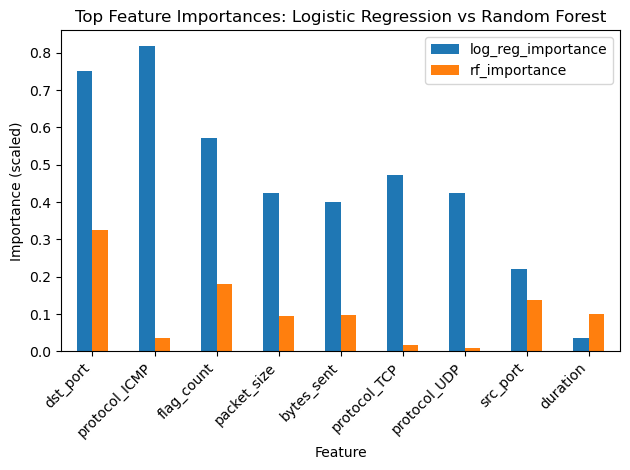

In [21]:
# Merge top-N features from logistic regression and random forest for comparison
top_n = 15

if log_reg_importance is not None and 'RandomForest' in tree_importances:
    lr_top = log_reg_importance[['feature', 'abs_coef']].rename(columns={'abs_coef': 'log_reg_importance'})
    rf_top = tree_importances['RandomForest'][['feature', 'importance']].rename(columns={'importance': 'rf_importance'})

    merged = pd.merge(lr_top, rf_top, on='feature', how='outer').fillna(0.0)
    merged['combined'] = merged['log_reg_importance'] + merged['rf_importance']
    merged_top = merged.sort_values('combined', ascending=False).head(top_n)

    merged_top = merged_top.set_index('feature')
    display(merged_top)

    # Bar plot for comparison
    plt.figure(figsize=(10, 6))
    merged_top[['log_reg_importance', 'rf_importance']].plot(kind='bar')
    plt.title('Top Feature Importances: Logistic Regression vs Random Forest')
    plt.ylabel('Importance (scaled)')
    plt.xlabel('Feature')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print('Insufficient importance data to build comparison plot.')